In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/ASAP2_train_sourcetexts.csv', encoding='ISO-8859-1')
print(df.head())

               essay_id  score  \
0  AAAVUP14319000159574      4   
1  AAAVUP14319000159542      2   
2  AAAVUP14319000159461      3   
3  AAAVUP14319000159420      2   
4  AAAVUP14319000159419      2   

                                           full_text  \
0  The author suggests that studying Venus is wor...   
1  NASA is fighting to be alble to to go to Venus...   
2  "The Evening Star", is one of the brightest po...   
3  The author supports this idea because from rea...   
4  How the author supports this idea is that he s...   

                                          assignment      prompt_name  \
0  In "The Challenge of Exploring Venus," the aut...  Exploring Venus   
1  In "The Challenge of Exploring Venus," the aut...  Exploring Venus   
2  In "The Challenge of Exploring Venus," the aut...  Exploring Venus   
3  In "The Challenge of Exploring Venus," the aut...  Exploring Venus   
4  In "The Challenge of Exploring Venus," the aut...  Exploring Venus   

       economically

In [5]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24728 entries, 0 to 24727
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   essay_id                    24728 non-null  object 
 1   score                       24728 non-null  int64  
 2   full_text                   24728 non-null  object 
 3   assignment                  24728 non-null  object 
 4   prompt_name                 24728 non-null  object 
 5   economically_disadvantaged  20723 non-null  object 
 6   student_disability_status   20723 non-null  object 
 7   ell_status                  24286 non-null  object 
 8   source_text_1               24728 non-null  object 
 9   Unnamed: 9                  0 non-null      float64
 10  Unnamed: 10                 0 non-null      float64
 11  Unnamed: 11                 0 non-null      float64
 12  Unnamed: 12                 0 non-null      float64
 13  Unnamed: 13                 0 n

In [6]:
!pip install -U language-tool-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 4.9 MB/s eta 0:00:00


In [7]:
!sudo apt update
!sudo apt install openjdk-17-jdk -y
!update-alternatives --install /usr/bin/java java /usr/lib/jvm/java-17-openjdk-amd64/bin/java 1
!update-alternatives --set java /usr/lib/jvm/java-17-openjdk-amd64/bin/java
!java -version

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,719 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,991 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-sec

In [15]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [8]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import language_tool_python
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Masking, Bidirectional, LSTM, Dropout, Concatenate, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, cohen_kappa_score
import matplotlib.pyplot as plt

In [10]:
df = df[['essay_id', 'score', 'full_text', 'assignment', 'prompt_name', 'ell_status', 'source_text_1']].copy()


In [ ]:
def clean_text(text):
    text = re.sub(r'<[^>]+>', '', str(text))            
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)          
    text = ' '.join(text.split())                        
    return text.strip()
df['clean_text'] = df['full_text'].apply(clean_text)

In [ ]:
tool = language_tool_python.LanguageTool('en-US')


def extract_features(row):
    text = row['clean_text']
    ell = 1 if row['ell_status'] == 'ELL' else 0
    num_words = len(word_tokenize(text))
    num_sentences = len(sent_tokenize(text))
    num_errors = len(tool.check(text))
    return pd.Series([num_words, num_sentences, ell, num_errors])


INFO:language_tool_python.download_lt:Unzipping /tmp/tmp5xemymqq.zip to /root/.cache/language_tool_python.
INFO:language_tool_python.download_lt:Downloaded https://internal1.languagetool.org/snapshots/LanguageTool-latest-snapshot.zip to /root/.cache/language_tool_python.


In [ ]:
df[['num_words', 'num_sentences', 'is_ell', 'grammar_errors']] = df.apply(extract_features, axis=1)

In [ ]:
sbert = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:

def get_sbert_sequence(text, max_sentences=20):
    sentences = sent_tokenize(text)
    sentences = sentences[:max_sentences]  
    embeddings = sbert.encode(sentences)    


    if len(embeddings) < max_sentences:
        padding = np.zeros((max_sentences - len(embeddings), embeddings.shape[1]))
        embeddings = np.vstack((embeddings, padding))

    return embeddings

In [ ]:

X_seq_full = np.array(df['clean_text'].apply(get_sbert_sequence).tolist()).astype('float32')


X_feat_full = df[['num_words', 'num_sentences', 'is_ell', 'grammar_errors']].values.astype('float32')


y_full = df['score'].values.astype('float32')


In [ ]:
X_seq_train, X_seq_test, X_feat_train_raw, X_feat_test_raw, y_train, y_test = train_test_split(
    X_seq_full, X_feat_full, y_full, test_size=0.2, random_state=42
)

In [ ]:
scaler = StandardScaler()
X_feat_train = scaler.fit_transform(X_feat_train_raw)
X_feat_test = scaler.transform(X_feat_test_raw)


sequence_length = X_seq_train.shape[1] 
input_dim = X_seq_train.shape[2]       
feature_dim = X_feat_train.shape[1]   


In [ ]:
input_seq = Input(shape=(sequence_length, input_dim))
x = Masking(mask_value=0.0)(input_seq)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(64))(x)
x = Dropout(0.3)(x)


input_feat = Input(shape=(feature_dim,))
f = Dense(32, activation='relu')(input_feat)


combined = Concatenate()([x, f])
combined = Dense(64, activation='relu')(combined)
combined = Dropout(0.2)(combined)
output = Dense(1, activation='linear')(combined)

model = Model(inputs=[input_seq, input_feat], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])


model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 20, 384)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 20, 384)   │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 20, 384)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 20)        │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 20, 256)   │    525,312 │ masking[0][0],    │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 20, 256)   │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │    164,352 │ dropout[0][0],    │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        160 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160)       │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     10,304 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 700,193 (2.67 MB)

 Trainable params: 700,193 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(
    [X_seq_train, X_feat_train], y_train,
    epochs=20,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/20
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - loss: 1.1586 - mae: 0.7764 - val_loss: 0.3750 - val_mae: 0.4781
Epoch 2/20
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 0.4944 - mae: 0.5524 - val_loss: 0.3653 - val_mae: 0.4614
Epoch 3/20
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.4524 - mae: 0.5261 - val_loss: 0.3683 - val_mae: 0.4753
Epoch 4/20
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.4403 - mae: 0.5180 - val_loss: 0.3756 - val_mae: 0.4648
Epoch 5/20
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.4056 - mae: 0.4985 - val_loss: 0.3723 - val_mae: 0.4667
Epoch 6/20
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 0.4051 - mae: 0.4995 - val_loss: 0.3518 - val_mae: 0.4509
Epoch 7/20
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.3845 - mae: 0.4866 - val_loss: 0.3459 - val_mae: 0.4512
Epoch 8/20
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.3700 - mae: 0.4757 - val_loss: 0.3481 - val_mae: 0.4535
Epoch 9/20
1113/1113 ━━━

In [ ]:

preds= model.predict([X_seq_test, X_feat_test]).flatten()

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [ ]:

mae = mean_absolute_error(y_test, preds_continuous)
rmse = np.sqrt(mean_squared_error(y_test, preds_continuous))

In [ ]:

valid_scores = sorted(df['score'].unique())
def round_to_valid(p):
    return min(valid_scores, key=lambda x: abs(x - p))

preds_rounded = np.array([round_to_valid(p) for p in preds_continuous])
y_test_rounded = np.array([round_to_valid(v) for v in y_test])

qwk = cohen_kappa_score(preds_rounded, y_test_rounded, weights='quadratic')

print(f"✅ MAE  : {mae:.4f}")
print(f"✅ RMSE : {rmse:.4f}")
print(f"✅ QWK  : {qwk:.4f}")

✅ MAE  : 0.4622
✅ RMSE : 0.5943
✅ QWK  : 0.7637


In [ ]:
comparison_df = pd.DataFrame({
      'Actual':  y_test,
      'Predicted':  preds,
      'Predicted_rounded':  preds_rounded
})
print("\nFirst 20 compare between Actual & Predicted")
print(comparison_df.head(20))


First 20 compare between Actual & Predicted
    Actual  Predicted  Predicted_rounded
0      3.0   3.600962                  4
1      2.0   2.344470                  2
2      2.0   2.394299                  2
3      3.0   3.596199                  4
4      2.0   2.211021                  2
5      4.0   3.483022                  3
6      1.0   2.862950                  3
7      2.0   2.122858                  2
8      3.0   3.967980                  4
9      5.0   3.945661                  4
10     4.0   3.061115                  3
11     3.0   3.291346                  3
12     4.0   3.500508                  4
13     3.0   2.879583                  3
14     4.0   3.369994                  3
15     1.0   1.768617                  2
16     3.0   3.126498                  3
17     1.0   2.142889                  2
18     2.0   2.561126                  3
19     2.0   2.678469                  3


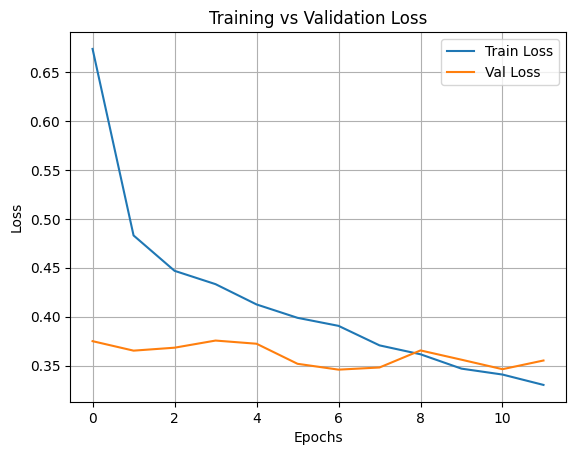

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

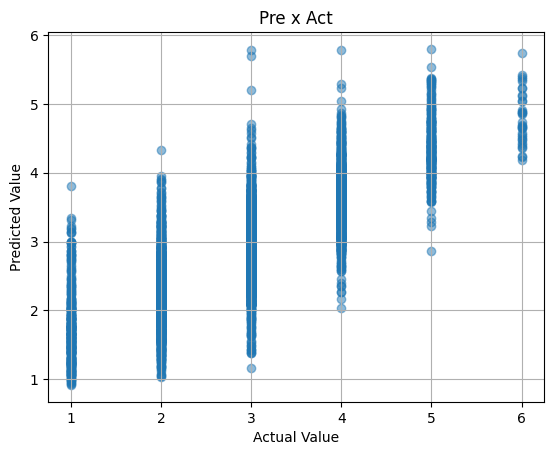

In [40]:
import matplotlib.pyplot as plt

plt.scatter(y_test, preds, alpha=0.5)
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.title("Pre x Act")
plt.grid()
plt.show()